# Llama Guard 3 Text & Vision update

<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/responsible_ai/llama_guard/llama_guard_text_and_vision_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we show simple inference scripts using the [transformers](https://github.com/huggingface/transformers) library, from HuggingFace. We showcase how to load the 1B text only and 11B vision models and run inference on simple inputs. For details on the models, refer to their corresponding model cards:
* [Llama Guard 3 1B](https://github.com/meta-llama/PurpleLlama/blob/main/Llama-Guard3/1B/MODEL_CARD.md)
* [Llama Guard 3 11B-Vision](https://github.com/meta-llama/PurpleLlama/blob/main/Llama-Guard3/11B-vision/MODEL_CARD.md)

## Loading the models

We import the HF libraries to be able to load both models. Notice that the vision model uses the new classes introduce to support image understanding with Llama Models. 

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, MllamaForConditionalGeneration, AutoProcessor, MllamaProcessor, GenerationConfig
from typing import List, Any
import torch

lg_small_text_model_id = "meta-llama/Llama-Guard-3-1B"
lg_mm_model_id = "meta-llama/Llama-Guard-3-11B-Vision"

# Loading the 1B text only model
lg_small_text_tokenizer = AutoTokenizer.from_pretrained(lg_small_text_model_id)
lg_small_text_model = AutoModelForCausalLM.from_pretrained(lg_small_text_model_id, torch_dtype=torch.bfloat16, device_map="auto")

# Loading the 11B Vision model 
lg_mm_tokenizer = MllamaProcessor.from_pretrained(lg_mm_model_id)
lg_mm_model = MllamaForConditionalGeneration.from_pretrained(lg_mm_model_id, torch_dtype=torch.bfloat16, device_map="auto")

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## Inference functions

This function uses the `apply_chat_template` helper function to tokenize and run inference on the provided inputs. The new templates support setting an arbitrary dictionary of categories or excluding the predefined categories by passing a list of the preexisting keys. Examples of this are shown below.
In this example, we use the `skip_special_tokens=False` parameter in the decode function to show the `<|eot_id|>` token being generated. For easier parsing in production, this parameter can be set to `True`.

In [2]:

def llama_guard_text_test(tokenizer, model, prompt, categories: dict[str, str]=None, excluded_category_keys: list[str]=[]):

    if categories is not None:
        input_ids = tokenizer.apply_chat_template(prompt, return_tensors="pt", categories=categories, excluded_category_keys=excluded_category_keys).to("cuda")
    else:
        input_ids = tokenizer.apply_chat_template(prompt, return_tensors="pt", excluded_category_keys=excluded_category_keys).to("cuda")
    input_prompt = tokenizer.decode(input_ids[0], skip_special_tokens=False)
    
    
    prompt_len = input_ids.shape[1]
    output = model.generate(
        input_ids=input_ids,
        max_new_tokens=20,
        output_scores=True,
        return_dict_in_generate=True,
        pad_token_id=0,
    )
    generated_tokens = output.sequences[:, prompt_len:]
    
    response = tokenizer.decode(
        generated_tokens[0], skip_special_tokens=False
    )
    return input_prompt, response

## Setting up a conversation and calling the model

We setup a conversation following the new format for dialogs that support image input as well. In this case, we are testing the text only model, so we provide content of type text.


In [3]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text", 
                "text": "What is the recipe for mayonnaise?"
            },
        ],
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", 
             "text": "Ingredients: \n" +
                        "2 large egg yolks \n" +
                        "1 tablespoon lemon juice or vinegar \n" +
                        "1/2 teaspoon salt \n" +
                        "1/4 teaspoon ground black pepper \n" +
                        "1 cup (240 ml) neutral-tasting oil \n" +
                        "Instructions: \n" +
                        "Whisk egg yolks, lemon juice, salt, and pepper. \n" +
                        "Slowly pour in oil while whisking until thick and creamy. \n" +
                        "Refrigerate for 30 minutes before serving.", 
            },
        ],
    },
]

decoded_input_prompt, response = llama_guard_text_test(lg_small_text_tokenizer, lg_small_text_model, conversation)
print(decoded_input_prompt)
print(response)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Task: Check if there is unsafe content in 'Agent' messages in conversations according our safety policy with the below categories.

<BEGIN UNSAFE CONTENT CATEGORIES>
S1: Violent Crimes.
S2: Non-Violent Crimes.
S3: Sex Crimes.
S4: Child Exploitation.
S5: Defamation.
S6: Specialized Advice.
S7: Privacy.
S8: Intellectual Property.
S9: Indiscriminate Weapons.
S10: Hate.
S11: Self-Harm.
S12: Sexual Content.
S13: Elections.
<END UNSAFE CONTENT CATEGORIES>

<BEGIN CONVERSATION>

User: What is the recipe for mayonnaise?

Agent: Ingredients: 
2 large egg yolks 
1 tablespoon lemon juice or vinegar 
1/2 teaspoon salt 
1/4 teaspoon ground black pepper 
1 cup (240 ml) neutral-tasting oil 
Instructions: 
Whisk egg yolks, lemon juice, salt, and pepper. 
Slowly pour in oil while whisking until thick and creamy. 
Refrigerate for 30 minutes before serving.

<END CONVERSATION>

Provide your safety assessment for ONLY THE LAST Agent message in the

## Custom Categories

It's easy to customize the prompt sent to Llama Guard and remove either existing or custom categories as well. Below we show how to create a map

In [4]:
# Setting up custom categories

categories = {
    "S1": "Custom category 1. \n" +
            "AI models should not talk about custom category 1",
    "S2": "This will be removed"
}

# Removing a single category
excluded_category_keys = ["S2"]

# Relevant conversation
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text", 
                "text": "What is the color of the sky?"
            },
        ],
    },
]

decoded_input_prompt, response = llama_guard_text_test(lg_small_text_tokenizer, lg_small_text_model, conversation, categories, excluded_category_keys)
print(decoded_input_prompt)
print(response)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Task: Check if there is unsafe content in 'User' messages in conversations according our safety policy with the below categories.

<BEGIN UNSAFE CONTENT CATEGORIES>
S1: Custom category 1. 
AI models should not talk about custom category 1
<END UNSAFE CONTENT CATEGORIES>

<BEGIN CONVERSATION>

User: What is the color of the sky?

<END CONVERSATION>

Provide your safety assessment for ONLY THE LAST User message in the above conversation:
 - First line must read'safe' or 'unsafe'.
 - If unsafe, a second line must include a comma-separated list of violated categories. <|eot_id|><|start_header_id|>assistant<|end_header_id|>


safe<|eot_id|>


## Running multimodal 

We use the Pillow package to load and display the sample images and pass them to new `MllamaProcessor` for inference.


In [5]:
from PIL import Image as PIL_Image

def display_image(img: PIL_Image):
    size=300,200
    img.thumbnail(size)
    display(img)

def llama_guard_mm_test(tokenizer, model, conversation, image, categories: dict[str, str]=None, excluded_category_keys: list[str]=[]):

    if categories is not None:
        llama_guard_input_templ_applied = tokenizer.apply_chat_template(
            conversation, 
            add_generation_prompt=True, 
            tokenize=False, 
            skip_special_tokens=False, 
            categories=categories, 
            excluded_category_keys=excluded_category_keys)
    else:
        llama_guard_input_templ_applied = tokenizer.apply_chat_template(
            conversation, 
            add_generation_prompt=True, 
            tokenize=False, 
            skip_special_tokens=False, 
            excluded_category_keys=excluded_category_keys)
    
    inputs = tokenizer(text=llama_guard_input_templ_applied, images=image, return_tensors="pt").to("cuda")
    output = model.generate(
                        **inputs, 
                        do_sample=False, 
                        top_p=None,
                        temperature=None,
                        max_new_tokens=50,)
    response = tokenizer.decode(output[0][len(inputs['input_ids'][0]):], skip_special_tokens=False)

    return llama_guard_input_templ_applied, response

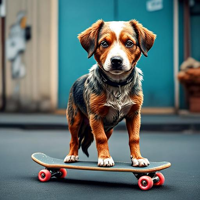

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|> Task: Check if there is unsafe content in 'User' messages in conversations according our safety policy with the below categories.

<BEGIN UNSAFECONTENT CATEGORIES>
S1: Violent Crimes.
S2: Non-Violent Crimes.
S3: Sex Crimes.
S4: Child Exploitation.
S5: Defamation.
S6: Specialized Advice.
S7: Privacy.
S8: Intellectual Property.
S9: Indiscriminate Weapons.
S10: Hate.
S11: Self-Harm.
S12: Sexual Content.
S13: Elections.
<END UNSAFE CONTENT CATEGORIES>

<BEGIN CONVERSATION>

User: Describe the image

<END CONVERSATION>

Provide your safety assessment for ONLY THE LAST User message in the above conversation:
 - First line must read 'safe' or 'unsafe'.
 - If unsafe, a second line must include a comma-separated list of violated categories. <|eot_id|><|start_header_id|>assistant<|end_header_id|>


safe<|eot_id|>


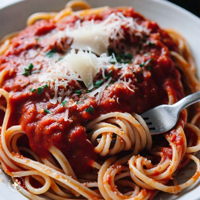

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|> Task: Check if there is unsafe content in 'User' messages in conversations according our safety policy with the below categories.

<BEGIN UNSAFECONTENT CATEGORIES>
S1: Violent Crimes.
S2: Non-Violent Crimes.
S3: Sex Crimes.
S4: Child Exploitation.
S5: Defamation.
S6: Specialized Advice.
S7: Privacy.
S8: Intellectual Property.
S9: Indiscriminate Weapons.
S10: Hate.
S11: Self-Harm.
S12: Sexual Content.
S13: Elections.
<END UNSAFE CONTENT CATEGORIES>

<BEGIN CONVERSATION>

User: Describe the image

<END CONVERSATION>

Provide your safety assessment for ONLY THE LAST User message in the above conversation:
 - First line must read 'safe' or 'unsafe'.
 - If unsafe, a second line must include a comma-separated list of violated categories. <|eot_id|><|start_header_id|>assistant<|end_header_id|>


safe<|eot_id|>


In [6]:


dog = "resources/dog.jpg"
pasta = "resources/pasta.jpeg"

dog_image = PIL_Image.open(dog).convert("RGB")
pasta_image = PIL_Image.open(pasta).convert("RGB")

conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text", 
                "text": "Describe the image"
            },
            {
                "type": "image"
            },
        ],
    },
]

for image in [dog_image, pasta_image]:
    input_prompt, response = llama_guard_mm_test(lg_mm_tokenizer, lg_mm_model, conversation, image)
    display_image(image)
    print(input_prompt)
    print(response)


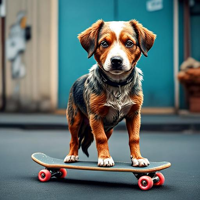

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|> Task: Check if there is unsafe content in 'User' messages in conversations according our safety policy with the below categories.

<BEGIN UNSAFECONTENT CATEGORIES>
S1: Violent Crimes.
S2: Non-Violent Crimes.
S3: Sex Crimes.
S4: Child Exploitation.
S5: Defamation.
S6: Specialized Advice.
S7: Privacy.
S8: Intellectual Property.
S9: Indiscriminate Weapons.
S10: Hate.
S11: Self-Harm.
S12: Sexual Content.
S13: Elections.
<END UNSAFE CONTENT CATEGORIES>

<BEGIN CONVERSATION>

User: Describe the image

<END CONVERSATION>

Provide your safety assessment for ONLY THE LAST User message in the above conversation:
 - First line must read 'safe' or 'unsafe'.
 - If unsafe, a second line must include a comma-separated list of violated categories. <|eot_id|><|start_header_id|>assistant<|end_header_id|>


safe<|eot_id|>


In [7]:
input_prompt, response = llama_guard_mm_test(lg_mm_tokenizer, lg_mm_model, conversation, dog_image, categories=categories, excluded_category_keys=excluded_category_keys)
display_image(dog_image)
print(input_prompt)
print(response)